# Performance Comparison

In [8]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [10]:
logfiles = {
    'GTrXL': ['GTrXL-PPO_4204__20230511_185852_episode_log.txt', 'GTrXL-PPO_4204__20230511_185852_agent_reward_log.txt'],
    'PPO': [],
    'DQN': [],
    'A2C': [],
    'FIFO': ['FIFO_4204__20230511_185214_episode_log.txt', 'FIFO_4204__20230511_185214_agent_reward_log.txt'],
    'NJF':[],
    'EMPTY':['EMPTY_4204__20230514_205208_episode_log.txt', 'EMPTY_4204__20230514_205208_agent_reward_log.txt'],
    'RANDOM':[]
}

In [11]:
def load_logfiles(episode_log:str, reward_log:str):
    ep_log = pd.read_csv(episode_log, sep=',')
    agent_log = pd.read_csv(reward_log, sep=',')
    return ep_log, agent_log

In [12]:
def extract_kpi(episode_log:pd.DataFrame):
    perf_kpi = pd.DataFrame()
    perf_kpi['alpha'] = episode_log['alpha'].values
    perf_kpi['inventory'] = episode_log['inventory'].values
    perf_kpi['order_waiting_time'] = episode_log['order_waiting_time'].values
    perf_kpi['machines_working'] = episode_log['machines_working'].values
    perf_kpi['total_reward'] = episode_log['total_reward'].values
    perf_kpi['transp_working'] = episode_log['transp_working'].values
    perf_kpi['processed_orders'] = episode_log['processed_orders'].values
    return perf_kpi

In [21]:
def mean_kpi(perf_kpi:pd.DataFrame):
    means = {
        'alpha': perf_kpi['alpha'].mean(),
        'inventory': perf_kpi['inventory'].mean(),
        'order_waiting_time': perf_kpi['order_waiting_time'].mean(),
        'machines_working': perf_kpi['machines_working'].mean(),
        'max_reward': perf_kpi['total_reward'].max(),
        'transp_util': perf_kpi['transp_working'].mean(),
        'throughput': perf_kpi['processed_orders'].mean()
    } 
    for k, v in means.items():
        print(k, v)
    return means

In [19]:
def plot_kpi(perf_kpi:pd.DataFrame):
    kpis = ['alpha', 'inventory', 'order_waiting_time', 'machines_working', 'max_reward', 'transp_util', 'throughput']
    for kpi in kpis:
        if kpi in perf_kpi.columns:
            perf_kpi.plot.line(y=kpi)

# GTrXL-PPO

alpha 13.163636729999993
inventory 123.97428937200029
order_waiting_time 649.3027110339993
machines_working 0.4346380719999998
max_reward 268.40472
transp_util 0.7769920319999992
throughput 163.7219


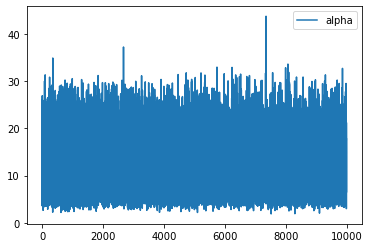

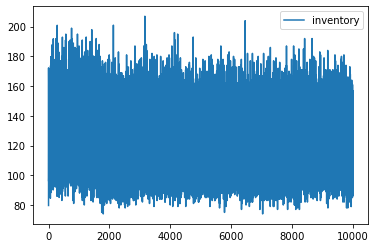

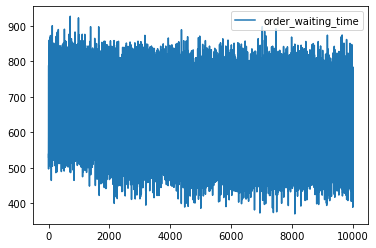

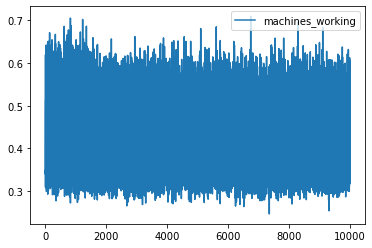

In [22]:
ep_log, agent_log = load_logfiles(logfiles['GTrXL'][0], logfiles['GTrXL'][1])
perf_kpis = extract_kpi(ep_log)
mean_kpis = mean_kpi(perf_kpis)
plot_kpi(perf_kpis)

# DQN

In [ ]:
ep_log, agent_log = load_logfiles(logfiles['DQN'][0], logfiles['DQN'][1])
perf_kpis = extract_kpi(ep_log)
mean_kpis = mean_kpi(perf_kpis)
plot_kpi(perf_kpis)

# PPO

In [ ]:
ep_log, agent_log = load_logfiles(logfiles['PPO'][0], logfiles['PPO'][1])
perf_kpis = extract_kpi(ep_log)
mean_kpis = mean_kpi(perf_kpis)
plot_kpi(perf_kpis)

# A2C

In [ ]:
ep_log, agent_log = load_logfiles(logfiles['A2C'][0], logfiles['A2C'][1])
perf_kpis = extract_kpi(ep_log)
mean_kpis = mean_kpi(perf_kpis)
plot_kpi(perf_kpis)

# FIFO

In [ ]:
ep_log, agent_log = load_logfiles(logfiles['FIFO'][0], logfiles['FIFO'][1])
perf_kpis = extract_kpi(ep_log)
mean_kpis = mean_kpi(perf_kpis)
plot_kpi(perf_kpis)

# NJF

In [ ]:
ep_log, agent_log = load_logfiles(logfiles['NJF'][0], logfiles['NJF'][1])
perf_kpis = extract_kpi(ep_log)
mean_kpis = mean_kpi(perf_kpis)
plot_kpi(perf_kpis)

# EMPTY

In [ ]:
ep_log, agent_log = load_logfiles(logfiles['EMPTY'][0], logfiles['EMPTY'][1])
perf_kpis = extract_kpi(ep_log)
mean_kpis = mean_kpi(perf_kpis)
plot_kpi(perf_kpis)

# RANDOM

In [ ]:
ep_log, agent_log = load_logfiles(logfiles['RANDOM'][0], logfiles['RANDOM'][1])
perf_kpis = extract_kpi(ep_log)
mean_kpis = mean_kpi(perf_kpis)
plot_kpi(perf_kpis)